# <center>  <font style="color:rgb(100,109,254)">Human Pose Estimation with OpenPose</font> </center>

**Note:** Download these 2 Models: [COCO](http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/coco/pose_iter_440000.caffemodel) & [MPII](http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/mpi/pose_iter_160000.caffemodel) , And put it inside the `Media/M4/Model` folder.

In this notebook we'll use a deep neural net called OpenPose which will let us do Pose detection in OpenCV. To be more specific OpenPose is actually a keypoint detection algorithm that will give us coordinates of the joints and other important keypoints in the human body. We may then use the information regarding the location of these points to determine the pose of the person. People have made some really interesting applications on top of keypoint detection algorithms, like this one application in which pose estimators check if you're making the correct yoga pose or if the you're exercising in the correct way.


![alt](Media/M4/final_pose.gif)

## <font style="color:rgb(134,19,348)"> Pose Detection Datasets: </font>

Some popular datasets for pose detection are :

- [**COCO Keypoints challenge**](http://cocodataset.org/#keypoints-2018)
- [**MPII Human Pose Dataset**](http://human-pose.mpi-inf.mpg.de/)
- [**VGG Pose Dataset**](http://www.robots.ox.ac.uk/~vgg/data/pose_evaluation/)


The OpenPose model that we'll be using is a caffe model that won COCO keypoint challange in 2016.

**Note:** The authors of the OpenPose paper have shared two models one model is trained on the Multi-Person Dataset ( MPII ) and the other one is trained on the COCO dataset. The MPII produces 15 points, this is the one we will be using in this notebook. The COCO model produces 18 points. You can download that model here.

Here are the results for both of them:

![alt](Media/M4/coco_mpi.png)

In [82]:
# Import Required libraries
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from tkinter import filedialog
from tkinter import Tk
%matplotlib inline

##  <font style="color:rgb(134,19,348)">Define Body Parts</font> 
The parts will be different depending upon the model you're using. 

In [84]:
# Select `coco` or `mpii`
model_type = 'mpii'

if model_type == 'mpii':
    # Here we are defining the names of each part/keypoint and its corresponding index.
        Body_parts = {"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                    "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                    "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
                    "Background": 15}

elif model_type == 'coco':
        # Here we are defining the names of each part/keypoint and its corresponding index.
        Body_parts = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                   "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                   "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
                   "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

## <font style="color:rgb(134,19,348)">Define Part Pairs</font> 
Here we're defining the pairs of parts that will be connected to make a skeleton, you don't need this if you're not going to draw the skeleton. Again the pairs depend upon which model you're using.

In [86]:
if model_type == 'mpii':
    part_pairs = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
                   ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
                   ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]
    
elif model_type == 'coco':
    part_pairs = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                   ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                   ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
                   ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

##  <font style="color:rgb(134,19,348)">Select Model Path</font> 
Set the required model path and its architecture.

In [87]:
if model_type == 'mpii':
     proto_file = "Media/M4/Model/pose_deploy_linevec_faster_4_stages.prototxt"
     weights = "Media/M4/Model/pose_iter_160000.caffemodel"
    
elif model_type == 'coco':
     proto_file = "Media/M4/Model/pose_deploy_linevec.prototxt"
     weights = "Media/M4/Model/pose_iter_440000.caffemodel"

## <font style="color:rgb(134,19,348)"> Initialize the DNN module </font>

In [88]:
net = cv2.dnn.readNetFromCaffe(proto_file, weights)

##  <font style="color:rgb(134,19,348)">Read Image</font> 


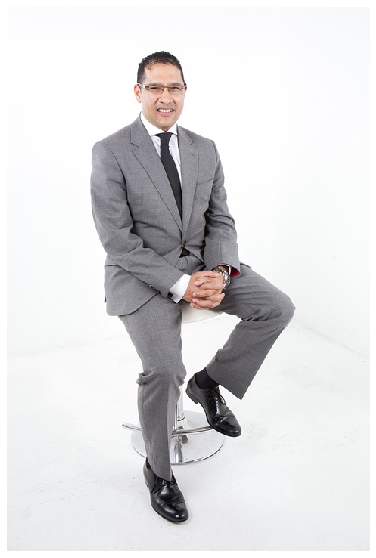

In [89]:
# Read image
image = cv2.imread("Media/M4/single2.jpg")

# Display image
plt.figure(figsize=[10,10])
plt.imshow(image[:,:,::-1])
plt.axis('off');

##  <font style="color:rgb(134,19,348)"> Pre-processing the image 
</font>

Reducing the size, increases speed but there is a drop in accuracy.

In [91]:
# Prepare the frame to be fed to the network
inpBlob  = cv2.dnn.blobFromImage(image, 1.0 / 255, (250, 250), (0, 0, 0), swapRB=False)

**Tip: For this particular model decreasing the width and height increases the speed but at the cost of accuracy**

##  <font style="color:rgb(134,19,348)">Forward Pass</font> 


In [93]:
%%time
net.setInput(inpBlob)
output = net.forward()

Wall time: 772 ms


In [94]:
print(output.shape)

(1, 44, 32, 32)


Above you can see we got 4D matrix lets understand about them a little bit.

**output:**

- **`1:`**	ImageID for one image if you pass more than 1 image it vaies 
- **`44:`**	 Index of the Keypoint, for MPI, it produces 44 points. that indicates the index of a keypoint in confidence map. The model produces Confidence maps and Part Affinity Maps, these are concatenated. So for MPII you get  15 probability maps & 44-15  = 29 Part Affinity maps. 
- **`32:`**	 Height of the output probability map & Affinity maps.
- **`32:`**	 Width of the output probability map & Affinity maps.

We won't be using Affinity maps, as you'll need those to do multipose detection. If you're interested in doing multi pose detection then take a look at this [blog post](https://www.learnopencv.com/multi-person-pose-estmation-in-opencv-using-openpose/).

##  <font style="color:rgb(134,19,348)">Iterate over all points and show their probablity maps </font> 


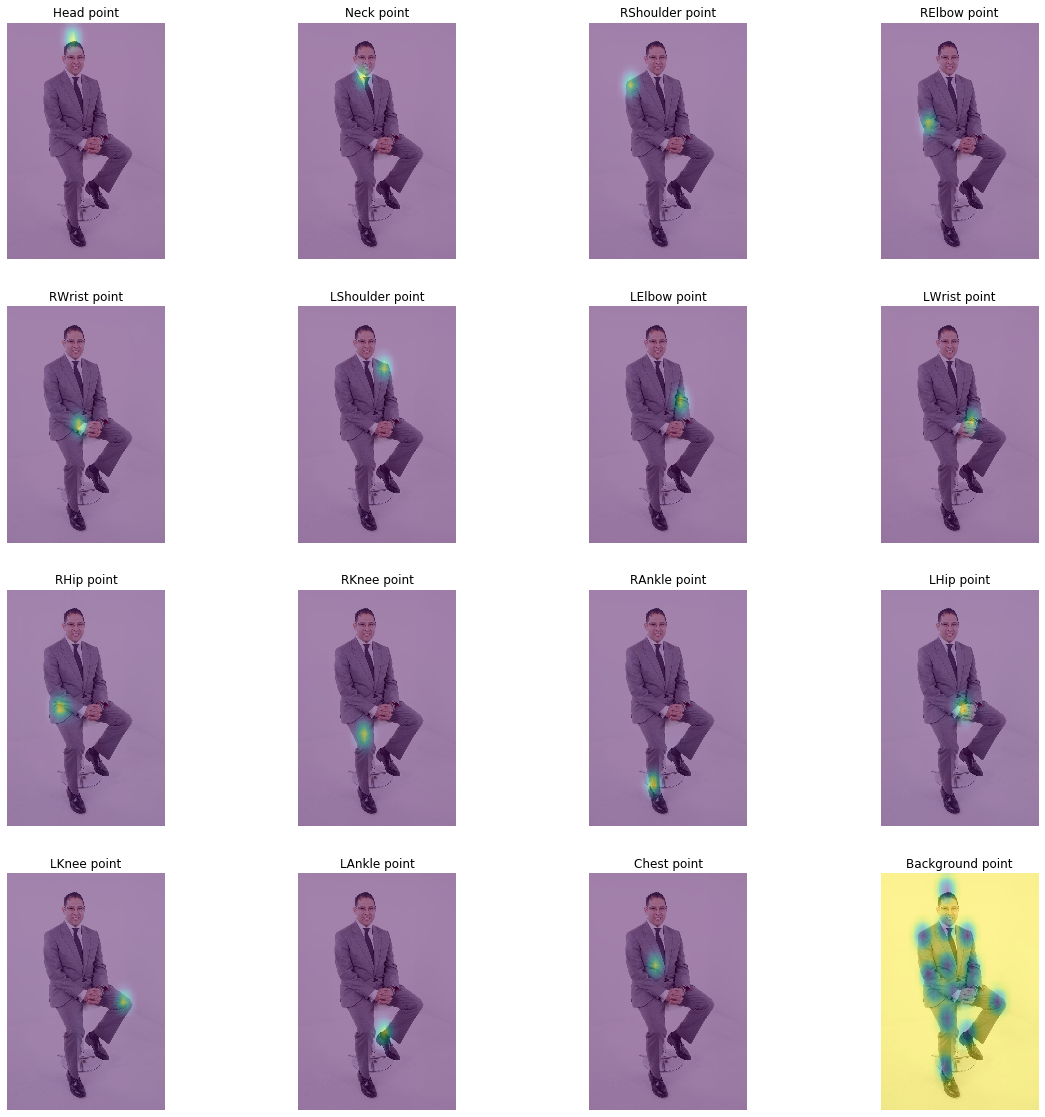

In [95]:
# Defining rows and columns
rows = 4;

height, width = image.shape[:2]

# Define Figure Size
plt.figure(figsize=(20,20));

# Show all points with prob map
for index, i in enumerate(Body_parts, 1):
    
    # Fetch the key point
    kp = Body_parts[i]
    
    # Fetch the specific point from porbablity map 
    pro_map = output[0, kp, :, :]
    
    # Here we have create the probablity same of image size 
    pro_map = cv2.resize(pro_map, (width, height))
    
    # Display it with probablity map 
    plt.subplot(rows, 4, index);plt.imshow(image[:,:,::-1]);plt.axis('off');

    # If you remove the probablity map you can't see the point in image
    plt.imshow(pro_map, alpha=0.5); plt.title("{} point".format(i));plt.axis('off');  

##  <font style="color:rgb(134,19,348)">Draw All individual points on original image </font> 


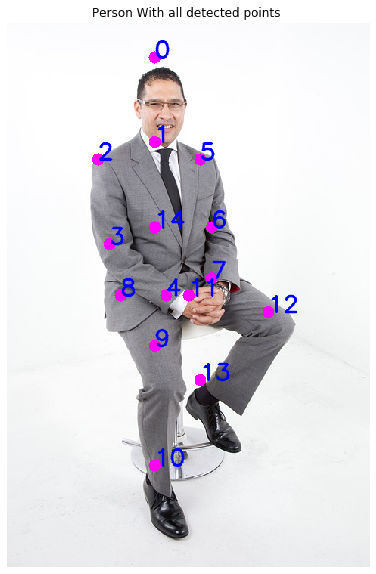

In [96]:
# Creating copy of image for showing point and skeleton of points 
img_copy = image.copy()
points = []

H = output.shape[2]
W = output.shape[3]

# Threshold value for the points to be consider 
threshold = 0.1

for i in range(len(Body_parts)-1):
    
    # Fetch the specific point from porbablity map 
    pro_map = output[0, i, :, :]
    
    # Find minimum and maximum value of probablity map 
    _ , max_probablity, _ , max_point = cv2.minMaxLoc(pro_map)
        
    # Scaling the points for the original image
    x = (width * max_point[0]) / W
    y = (height * max_point[1]) / H
    
    # If probablity value above than given threshold than draw consider that point
    if max_probablity > threshold :
      
        # Draw circle and put number on each point 
        cv2.circle(img_copy, (int(x), int(y)), 8, (255, 0, 255), thickness=-1)
        cv2.putText(img_copy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, 
                    lineType=cv2.LINE_AA)

        # Append point coordinates for futher use
        points.append((int(x), int(y)))
        
    else :
        points.append(None)

# Display image   
plt.figure(figsize=[10,10])        
plt.imshow(img_copy[:,:,::-1])
plt.title("Person With all detected points ")        
plt.axis('off');

##  <font style="color:rgb(134,19,348)"> Draw Skeleton </font> 


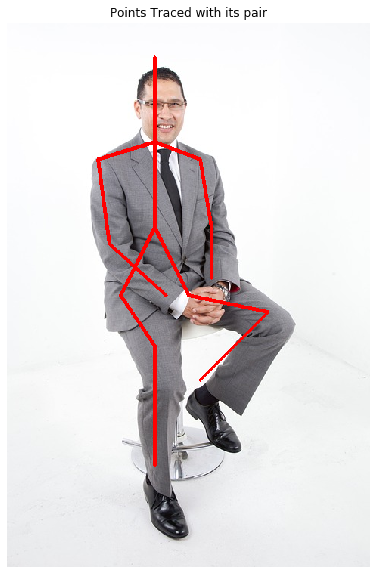

In [97]:
img_copy1 = image.copy()

# Tracing points according to its sekeleton and making a skeleton of body parts
for pair in part_pairs:
    A1 = Body_parts[pair[0]]
    B1 = Body_parts[pair[1]]

    if points[A1] and points[B1]:
        cv2.line(img_copy1, points[A1], points[B1], (0, 0, 255), 3)

# Display image         
plt.figure(figsize=[10,10])
plt.imshow(img_copy1[:,:,::-1])
plt.title("Points Traced with its pair")        
plt.axis('off');

##  <font style="color:rgb(134,19,348)"> Fetch point you need </font> 
This function can be used to fetch any point and visualize its probability map, Not required but might be useful.

In [98]:
def Fetchpoint(point):
    img_copy2 = image.copy()
    i = Body_parts[point]
    #Fetch the point from porbablity map 
    pro_map = output[0, i, :, :]

    #here we have create the probablity same of image size 
    pro_map = cv2.resize(pro_map, (width, height))

    #Display it with probablity map 
    plt.figure(figsize=[10,10])
    plt.imshow(image[:,:,::-1])

    #if you remove the probablity map you can't see the point in image
    plt.imshow(pro_map, alpha=0.5)
    plt.title("{} point".format(point))
    plt.axis("off")

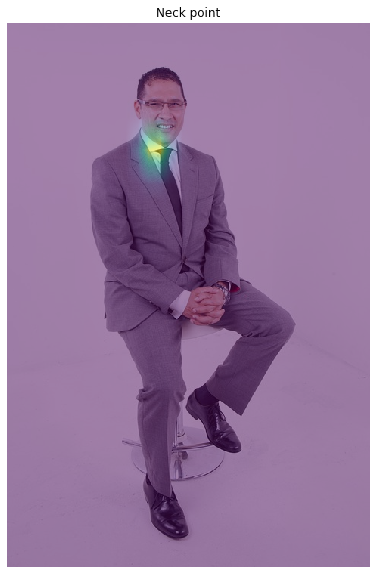

In [99]:
Fetchpoint("Neck")

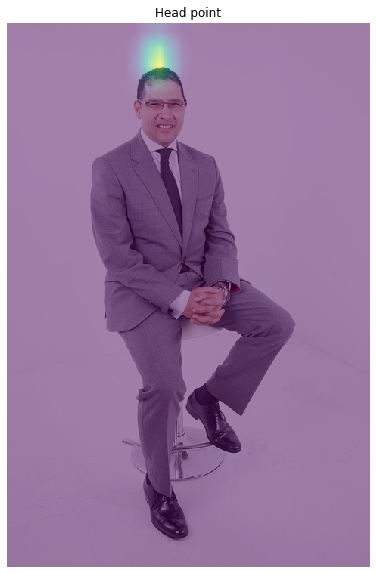

In [100]:
Fetchpoint("Head")

## <font style="color:rgb(134,19,348)"> Creating Functions </font> 

## <font style="color:rgb(134,19,348)"> Initialization Function </font>
This method will be run once and it will initialize the network with the required files.

In [101]:
def init_pose(usegpu = 'None',model_type="mpii"):
    
    # Set global variables
    global Body_parts,part_pairs,net,num_of_points
    
    
    if model_type == 'mpii':
        
        # Here we are defining the names of each part/keypoint and its corresponding index.
        Body_parts = {"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                    "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                    "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
                    "Background": 15}
        
        # Defining pair points for mpii
        part_pairs = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
                   ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
                   ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]
        
        # Defining model paths
        proto_file = "Media/M4/Model/pose_deploy_linevec_faster_4_stages.prototxt"
        weights = "Media/M4/Model/pose_iter_160000.caffemodel"
        
        
    elif model_type == 'coco':
        
        # Here we are defining the names of each part/keypoint and its corresponding index.
        Body_parts = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                   "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                   "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
                   "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 } 
        
        # Defining pair points for coco
        part_pairs = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                   ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                   ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
                   ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]    
        
        # Defining model paths
        proto_file = "Media/M4/Model/pose_deploy_linevec.prototxt"
        weights = "Media/M4/Model/pose_iter_440000.caffemodel" 
        
    # Defining number of points 
    num_of_points = len(Body_parts) - 1
        
    net = cv2.dnn.readNetFromCaffe(proto_file, weights)
    
    # If specified use either cuda based Nvidia gpu or opencl based Intel gpu.   
    if usegpu == 'cuda':
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
        
    elif usegpu == 'opencl':
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL)

## <font style="color:rgb(134,19,348)">  Main Method </font>

In [102]:
def pose(image=[], usercam=False,returndata=False,threshold=0.5,size=0.7,):
    
    # If the user did'nt specified the image then consider then consider choosing file or camera snapshot.
    if np.size(image) == 0:
        
        # If usercam cam is True then take picture from camera
        if usercam:
            cap=cv2.VideoCapture(0, cv2.CAP_DSHOW)
            ret, frame=cap.read()
            if ret:
                image= cv2.flip(frame,1)
                cap.release()
            else:
                print('Cant Open Camera')
                sys.exit()
                
        # Otherwise select image from computer using tkinter        
        else:
            root = Tk()
            root.filename =  filedialog.askopenfilename(title = "Pick up the Image")
            root.withdraw()
            image = cv2.imread(root.filename)
            
    (height,width) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0 / 255, (200, 240), (0, 0, 0), swapRB=False, crop=False)
    
    # Store all points in this variable
    points = []
    
    net.setInput(blob)
    output = net.forward()
    
    H = output.shape[2]
    W = output.shape[3]
    
    # Iterate all points
    for i in range(num_of_points):

        pro_map = output[0, i, :, :]
        _,probablity, _, point = cv2.minMaxLoc(pro_map)

        x = (width * point[0]) / W
        y = (height * point[1]) / H

        if probablity > threshold : 
            cv2.circle(image, (int(x), int(y)), 10, (255, 0, 255), thickness=-1, lineType=cv2.FILLED)
            points.append((int(x), int(y)))
        else :
            points.append(None)

    for pair in part_pairs:
        A1 = Body_parts[pair[0]]
        B1 = Body_parts[pair[1]]

        if points[A1] and points[B1]:
            cv2.line(image, points[A1], points[B1], (0, 0, 255), 3)
            
    if  returndata:
        return image
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(image[:,:,::-1]);plt.axis("off");          

**Initialize the Pose Estimator**

In [103]:
init_pose()

**Calling human pose with default arguments.**

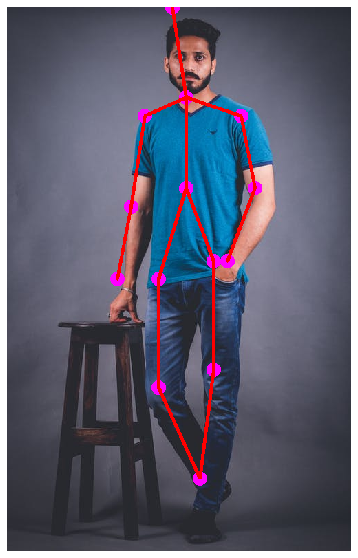

In [104]:
image = cv2.imread('Media/M4/man1.jpeg')
pose(image)

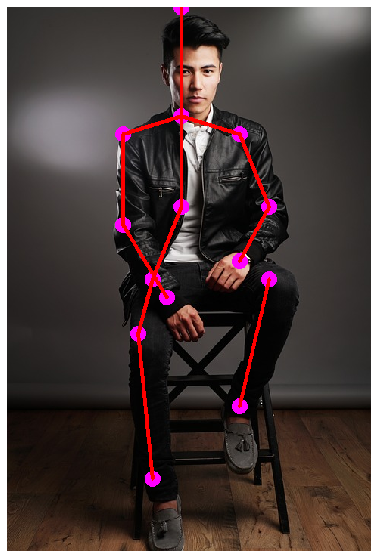

In [105]:
image = cv2.imread('Media/M4/single1.jpg')
pose(image)

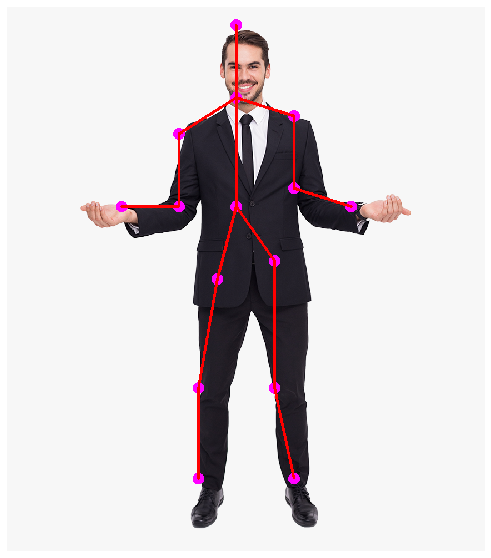

In [106]:
image = cv2.imread('Media/M4/man5.png')
pose(image)

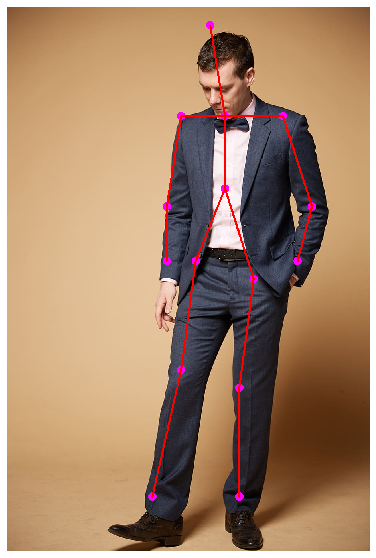

In [107]:
image = cv2.imread('Media/M4/man6.jpg')
pose(image)

####  Capturing Image from Camera

In [ ]:
pose(usercam=True)

## <font style="color:rgb(134,19,348)"> Using Intel & Nvidia GPUs </font>

**CPU Time**

In [ ]:
init_pose()

In [ ]:
%%time
image= pose(image = image, returndata=True)

**Intel GPU**

In [ ]:
init_pose(usegpu = 'opencl')

In [ ]:
%%time
image= pose(image = image, returndata=True)

**NVIDIA GPU**

In [ ]:
init_pose(usegpu = 'cuda')

In [ ]:
%%time
image= pose(image = image, returndata=True)

## <font style="color:rgb(134,19,348)">Pose Estimation on Video </font>

In [ ]:
# Initializing method
init_pose()

# Starting video reading mode
cap = cv2.VideoCapture('Media/M4/dpose.mp4')
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Specifying Video writing path
out = cv2.VideoWriter(r'Media/M4/posed.mp4',fourcc, 20.0, (700,500))

while(True):
    
    ret, frame = cap.read()
    if not ret:
        break
        
    pose = pose(frame,returndata=True)
    
    cv2.imshow('Pose Video',pose)
    out.write(pose)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
out.release()
cv2.destroyAllWindows()